In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
from sklearn.model_selection import GridSearchCV, KFold 

## Data-generating process

In [2]:
theta_0 = 1   # true ATE
mean = np.array([1, 0])
cov = np.array([[1, -0.2], [-0.2, 0.5]])
beta = np.array([1, 2, -1])
F = lambda z: 1 / (1 + np.exp(-z))   # standard logistic function

# Propensity score
m_0 = lambda x: F(x @ beta)

# Outcome regression function
def g_0(d, x):
    if x.ndim == 1:
        x = x.reshape(1,-1)
    return d*x[:,0] + F(x[:,1]) - 2*x[:,2]**2

In [3]:
# Generate a dataset of size N in a vectorized fashion
def get_data(N):
    x_12 = np.random.multivariate_normal(mean=mean, cov=cov, size=N)
    x_3 = np.random.uniform(size=N)
    x_data = np.concatenate((x_12, x_3.reshape(N,1)), axis=1)

    xi = np.random.logistic(size=N)
    d_data = (x_data @ beta + xi >= 0)
        
    u = np.random.normal(scale=x_3)
    y_data = g_0(d_data, x_data) + u 

    return y_data, d_data, x_data

## MC simulation of infeasible method-of-moments estimator

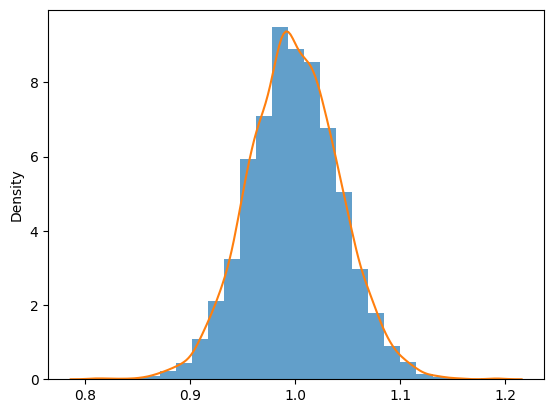

CPU times: total: 5.69 s
Wall time: 5.69 s


In [35]:
%%time
n_MC = 5000
N = 2000
infeasible_estimates_list = []

for j in range(n_MC):
    y_data, d_data, x_data = get_data(N)
    estimate = np.mean(g_0(1, x_data) - g_0(0, x_data) + d_data*(y_data-g_0(1, x_data))/m_0(x_data)
                       - (1-d_data)*(y_data-g_0(0, x_data))/(1-m_0(x_data)))
    infeasible_estimates_list.append(estimate)
    
plt.hist(infeasible_estimates_list, density=True, alpha=0.7, bins=25)
sns.kdeplot(infeasible_estimates_list)
plt.show()

In [36]:
np.mean(infeasible_estimates_list)

0.9987165898922377

In [37]:
np.std(infeasible_estimates_list)

0.04351164109384918

## Fix one dataset

In [41]:
np.random.seed(seed=123)
N = 2000
y_data, d_data, x_data = get_data(N)
print(f'Percentage of treated units: {np.mean(d_data)}')
np.mean(np.abs(y_data - g_0(d_data, x_data)))

Percentage of treated units: 0.586


0.4244602905789002

In [7]:
N_train = int(0.8 * N)
y_train, d_train, x_train = y_data[:N_train], d_data[:N_train], x_data[:N_train]
y_eval, d_eval, x_eval = y_data[N_train:], d_data[N_train:], x_data[N_train:]

## Tune ML estimators for this dataset / sample size

In [8]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')

param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'eta': [0.1, 0.2, 0.3],
    'lambda': [0.1, 1, 10] 
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

### For $g_0(1,X)=E[Y|D=1,X]$:

In [9]:
grid_search.fit(x_data[d_data==1], y_data[d_data==1])
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_g1 = grid_search.best_estimator_

Best Hyperparameters: {'colsample_bytree': 1.0, 'eta': 0.1, 'lambda': 1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Best Score: 0.7355894556825143


In [10]:
model_g1.fit(X=x_train[d_train==1], y=y_train[d_train==1])
print(f'Training error: {np.mean(np.abs(model_g1.predict(x_train) - g_0(1, x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_g1.predict(x_eval) - g_0(1, x_eval)))}')

Training error: 0.14669584980910355
Evaluation error: 0.16228104697099321


### For $g_0(0,\cdot)=E[Y|D=0,X]$:

In [11]:
grid_search.fit(x_data[d_data==0], y_data[d_data==0])
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_g0 = grid_search.best_estimator_

Best Hyperparameters: {'colsample_bytree': 1.0, 'eta': 0.3, 'lambda': 10, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
Best Score: 0.45789230324499075


In [12]:
model_g0.fit(X=x_train[d_train==0], y=y_train[d_train==0])
print(f'Training error: {np.mean(np.abs(model_g0.predict(x_train) - g_0(0, x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_g0.predict(x_eval) - g_0(0, x_eval)))}')

Training error: 0.13804172838135095
Evaluation error: 0.15110516743733496


In [13]:
model_g = [model_g0, model_g1]

### For $m_0(X)=E[D|X]$:

In [14]:
xgb_model = xgb.XGBRegressor(objective='reg:logistic', tree_method='hist')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

In [15]:
grid_search.fit(x_data, d_data)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
model_m = grid_search.best_estimator_

Best Hyperparameters: {'colsample_bytree': 0.7, 'eta': 0.1, 'lambda': 1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
Best Score: 0.23690283384232616


In [16]:
model_m.fit(X=x_train, y=d_train)
print(f'Training error: {np.mean(np.abs(model_m.predict(x_train) - m_0(x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_m.predict(x_eval) - m_0(x_eval)))}')

Training error: 0.057148393881640065
Evaluation error: 0.05642867471770378


## Hard-code best ML models to avoid running CV everytime

In [42]:
model_g0 = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', colsample_bytree=1.0, 
                            eta=0.3, reg_lambda=10, max_depth=3, n_estimators=10, subsample=0.7)
model_g1 = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', colsample_bytree=1.0, 
                            eta=0.1, reg_lambda=1, max_depth=3, n_estimators=50, subsample=0.7)
model_g = [model_g0, model_g1]
model_m = xgb.XGBRegressor(objective='reg:logistic', tree_method='hist', colsample_bytree=0.7, 
                           eta=0.1, reg_lambda=1, max_depth=3, n_estimators=50, subsample=0.85)

## DML algorithm

In [17]:
# Neyman orthogonal score
def psi_ate(h_0, h_1, h_2, y, d, x, theta):
    return h_1(x) - h_0(x) + d*(y-h_1(x))/h_2(x) - (1-d)*(y-h_0(x))/(1-h_2(x)) - theta

In [62]:
def dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m):
    # Generate random partition of data for cross-fitting
    indices = np.arange(N)
    kf = KFold(n_splits=K, shuffle=True)#, random_state=42)

    # Compute respective ML estimators and thereupon auxiliary estimators
    theta_0_check = []
    reg_check, ipw_check = [], []
    for (train_indices, eval_indices) in kf.split(x_data):
        y_train, d_train, x_train = y_data[train_indices], d_data[train_indices], x_data[train_indices]
        y_eval, d_eval, x_eval = y_data[eval_indices], d_data[eval_indices], x_data[eval_indices]

        # Estimate outcome regression functions g_0(d)
        g_0_hat = []
        for d in [0,1]:
            model_g[d].fit(X=x_train[d_train==d], y=y_train[d_train==d])
            g_0_hat.append(model_g[d].predict(x_eval))

        # Estimate propensity score m_0
        model_m.fit(X=x_train, y=d_train)
        m_0_hat = model_m.predict(x_eval)
            
        # Compute auxiliary estimator
        theta_0_check.append(np.mean(g_0_hat[1] - g_0_hat[0] + d_eval*(y_eval-g_0_hat[1])/m_0_hat
                                     - (1-d_eval)*(y_eval-g_0_hat[0])/(1-m_0_hat)))

        # Regression estimator 
        reg_check.append(np.mean(g_0_hat[1] - g_0_hat[0]))
        # IPW estimator
        ipw_check.append(np.mean(d_eval*y_eval/m_0_hat - (1-d_eval)*y_eval/(1-m_0_hat)))

    # Compute final estimators
    theta_0_hat = np.mean(theta_0_check)
    reg_hat, ipw_hat = np.mean(reg_check), np.mean(ipw_check)

    return np.array([theta_0_hat, reg_hat, ipw_hat])

In [63]:
%%time
K = 5
dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m)

CPU times: total: 1.91 s
Wall time: 561 ms


array([1.03201225, 1.06738555, 1.07529085])

## MC simulation of DML

In [65]:
%%time
N = 2000
n_MC = 1000
K = 5
estimates_list = np.empty((n_MC, 3))

for j in range(n_MC):
    y_data, d_data, x_data = get_data(N)
    estimates_list[j] = dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m)

CPU times: total: 32min 31s
Wall time: 9min 12s


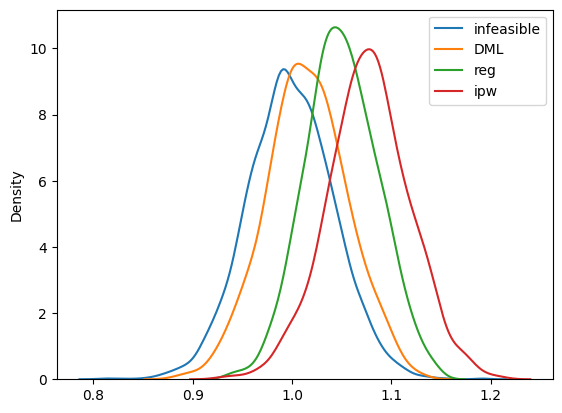

In [67]:
sns.kdeplot(infeasible_estimates_list, label='infeasible')
sns.kdeplot(estimates_list[:,0], label='DML')
sns.kdeplot(estimates_list[:,1], label='reg')
sns.kdeplot(estimates_list[:,2], label='ipw')
plt.legend()
plt.show()

In [69]:
print(f'Mean of estimates: {np.mean(estimates_list, axis=0)}')
print(f'Standard deviation of estimates: {np.std(estimates_list, axis=0)}')
print(f'MSE estimates: {np.mean((estimates_list-theta_0)**2, axis=0)}')

Mean of estimates: [1.01499534 1.05003732 1.0770717 ]
Standard deviation of estimates: [0.0408117  0.03637304 0.04142819]
MSE estimates: [0.00189046 0.00382673 0.00765634]
